# Swissroll with Dropouts
## Imports

In [1]:
from sklearn import datasets, neighbors, preprocessing
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams

# local imports
from os import chdir
chdir("../")

from sclllvm_test import scLL_LVM_test as scLL_LVM
from lllvm.plot import plot_C_arrows, plot_G
from lllvm.utils import infer_graph, initialize_t, initialize_C

chdir("demo")

# Plotting configuration
%matplotlib inline
#sns.set()

# True Data

In [2]:
np.random.seed(10)

x, t_true = datasets.make_swiss_roll(400)
x = (x - x.mean(0)) / x.std(0) / np.array([1,1,1])
t_true = (t_true - t_true.mean(0)) / t_true.std(0)
x = x.T
Dy, N = x.shape
Dt = 1

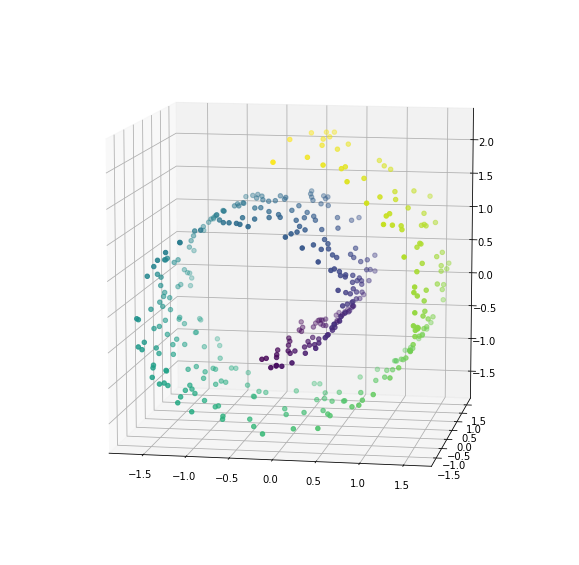

In [3]:
rcParams['figure.figsize'] = (10,10)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, -80)
ax.scatter(x[0,:], x[1,:], x[2,:], c=t_true, marker='o')
plt.show()

## Dropouts

In [27]:
p_drop = 0.05
ld = - np.log(p_drop)
y = x * np.random.binomial(1, 1 - p_drop, x.shape)

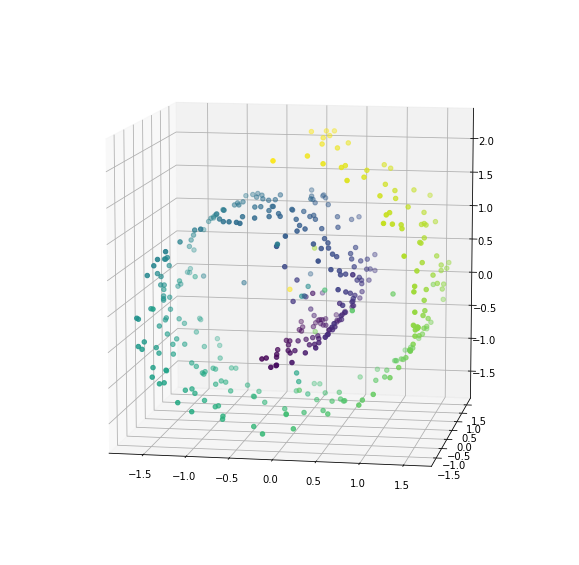

In [28]:
rcParams['figure.figsize'] = (10,10)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, -80)
ax.scatter(y[0,:], y[1,:], y[2,:], c=t_true, marker='o')
plt.show()

# Inferred Graph ($G$)

In [29]:
# build nearest neighbor graph
G = infer_graph(x, k=10, keep_asymmetries=True, delta=2.5)

### Graph in $x$-space

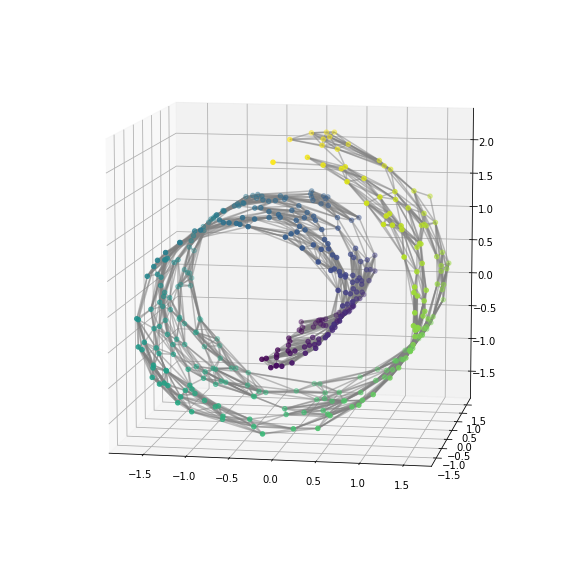

In [30]:
rcParams['figure.figsize'] = (10,10)
ax = plot_G(G=G, t=t_true, x=x, alpha_G=0.5)
ax.view_init(10, -80)

### Graph in $y$-space

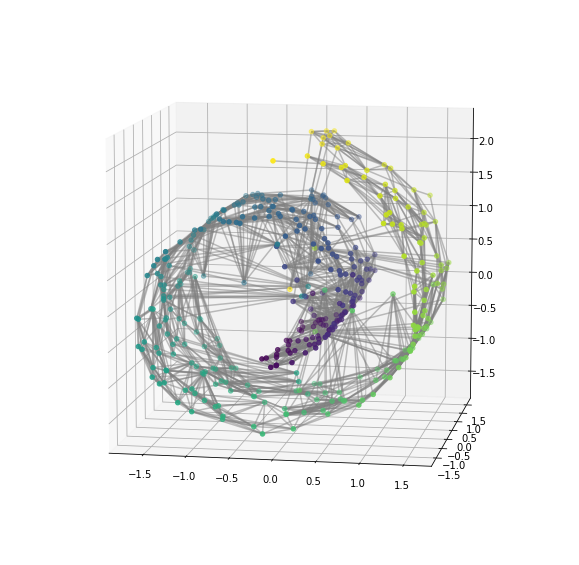

In [31]:
rcParams['figure.figsize'] = (10,10)
ax = plot_G(G=G, t=t_true, x=y, alpha_G=0.5)
ax.view_init(10, -80)

# Model
## Initialize $t$ from $G$ and $y$

In [32]:
t_init = initialize_t(G, y)

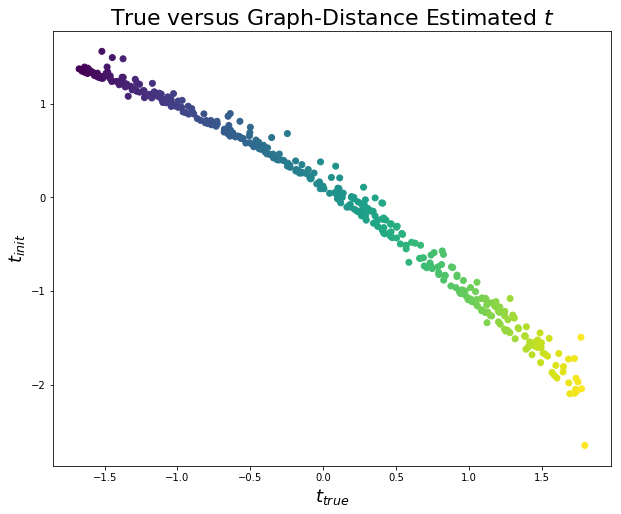

Correlation: -0.988009


In [33]:
rcParams['figure.figsize'] = (10,8)
plt.scatter(t_true, t_init, c=t_true)
plt.xlabel("$t_{true}$", fontsize=18)
plt.ylabel("$t_{init}$", fontsize=18)
plt.title("True versus Graph-Distance Estimated $t$", fontsize=22)
plt.show()
print("Correlation: %f" % np.corrcoef(t_true.flatten(), t_init.flatten())[0,1])

## Initialize $C$ from $G,y$ and $t_\text{init}$

In [34]:
C_init = initialize_C(y, t_init, G)

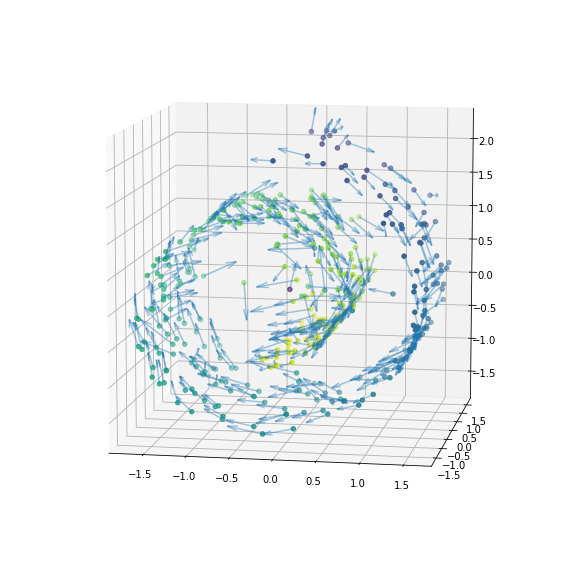

In [36]:
rcParams['figure.figsize'] = (10,10)
ax = plot_C_arrows(y, t_init, C_init, scale_C=0.1, alpha_C=0.4)
ax.view_init(10, -80)

## Initialize Model

In [78]:
#set user-defined parameters
alpha = 10
gamma = 5.0
epsilon = 0.00001
V_inv = gamma * np.identity(Dy)

model = scLL_LVM(G, epsilon, alpha, V_inv, C_init, t_init, y, y, 0.01, 0.001, 0.01, ld)

# Sampling
### burn in

In [79]:
n_burn = 200000

for i in range(n_burn):
    print("\rStep %d of %d; log-likelihood = %f" % (i+1,n_burn, model.likelihoods[-1]), end="")
    model.MH_step(burn_in=True)

Step 200000 of 200000; log-likelihood = -4029.977873

### samples

In [80]:
n_samp = 100000

for i in range(n_samp):
    print("\rStep %d of %d; log-likelihood = %f" % (i+1,n_samp, model.likelihoods[-1]), end="")
    model.MH_step(burn_in=False)

Step 100000 of 100000; log-likelihood = -3782.737891

In [81]:
print("Acceptance rate: %.8f" % model.accept_rate)

Acceptance rate: 0.34018333


# Diagnostic Plots
### Full Likelihood History

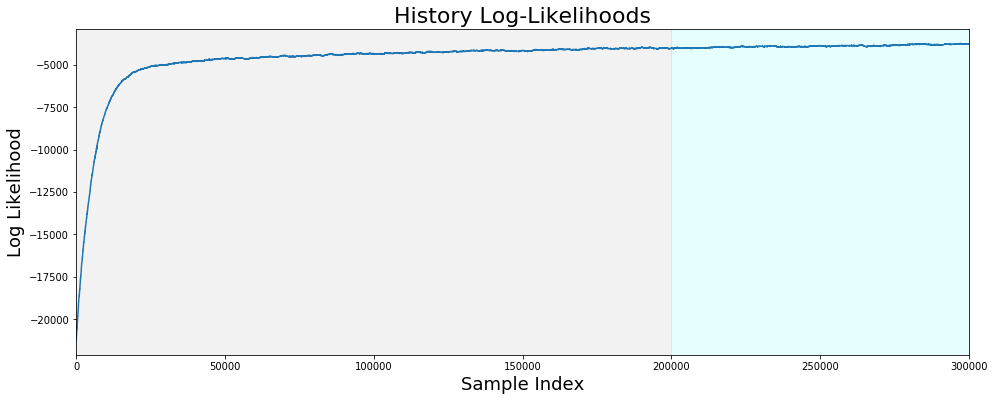

In [82]:
rcParams['figure.figsize'] = (16,6)
plt.plot(model.likelihoods)
plt.axvspan(0, n_burn, alpha=0.1, color='grey')
plt.axvspan(n_burn, n_samp + n_burn, alpha=0.1, color='cyan')
plt.xlim(0,n_samp + n_burn)
plt.title("History Log-Likelihoods", fontsize=22)
plt.ylabel("Log Likelihood", fontsize=18)
plt.xlabel("Sample Index", fontsize=18);

### Sample Likelihoods

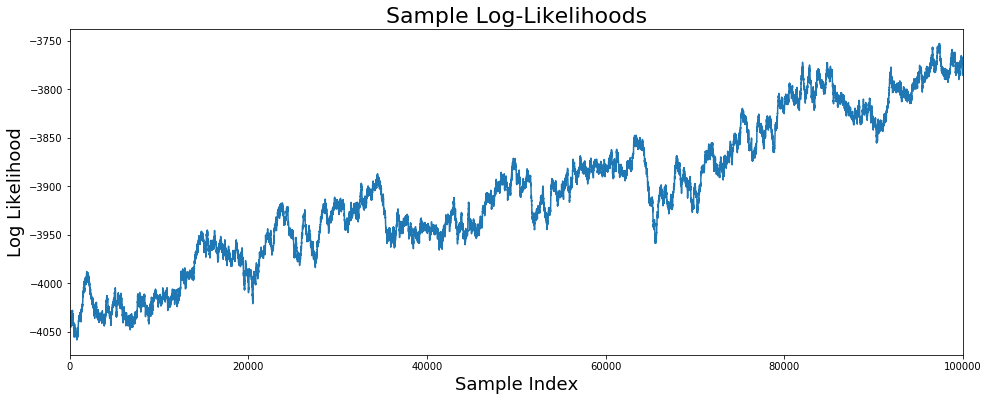

In [83]:
rcParams['figure.figsize'] = (16,6)
plt.plot(model.likelihoods[(n_burn-1):-1])
plt.xlim(0,n_samp)
plt.title("Sample Log-Likelihoods", fontsize=22)
plt.ylabel("Log Likelihood", fontsize=18)
plt.xlabel("Sample Index", fontsize=18);

### Likelihood $C$ Component History

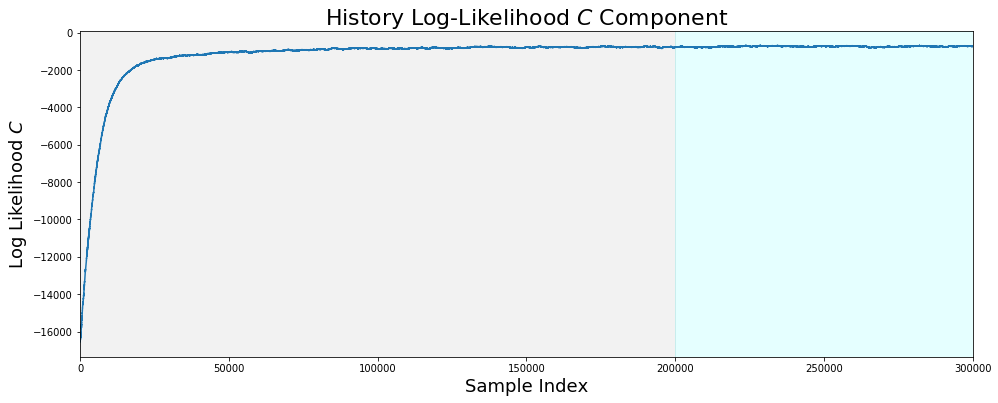

In [84]:
rcParams['figure.figsize'] = (16,6)
plt.plot(model.ll_comp_C)
plt.axvspan(0, n_burn, alpha=0.1, color='grey')
plt.axvspan(n_burn, n_samp + n_burn, alpha=0.1, color='cyan')
plt.xlim(0,n_samp + n_burn)
plt.title("History Log-Likelihood $C$ Component", fontsize=22)
plt.ylabel("Log Likelihood $C$", fontsize=18)
plt.xlabel("Sample Index", fontsize=18);

### Likelihood $C$ Component Samples

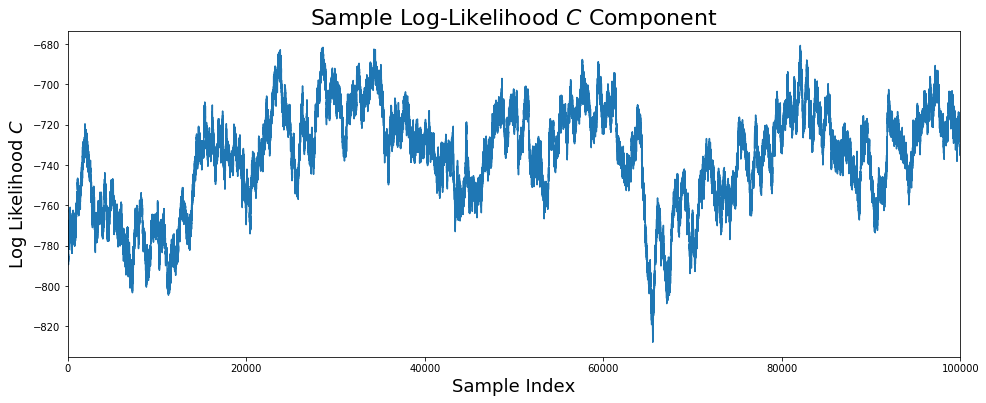

In [85]:
rcParams['figure.figsize'] = (16,6)
plt.plot(model.ll_comp_C[(n_burn-1):-1])
plt.xlim(0,n_samp)
plt.title("Sample Log-Likelihood $C$ Component", fontsize=22)
plt.ylabel("Log Likelihood $C$", fontsize=18)
plt.xlabel("Sample Index", fontsize=18);


### Likelihood $t$ Component History

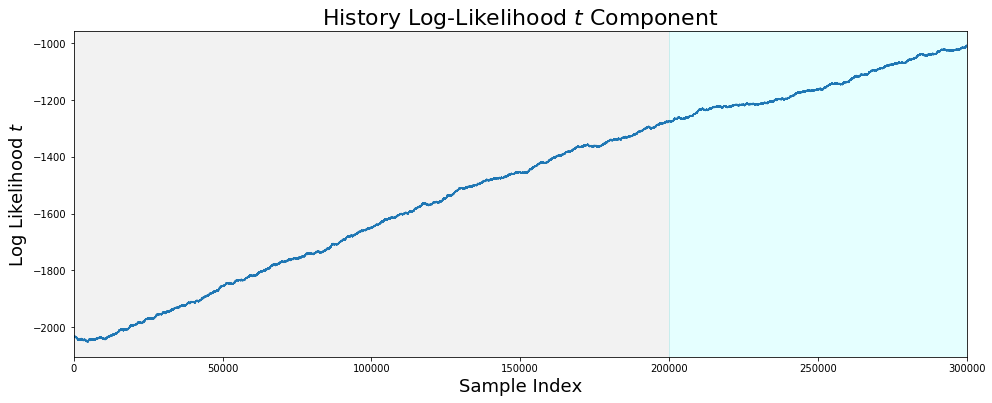

In [86]:
rcParams['figure.figsize'] = (16,6)
plt.plot(model.ll_comp_t)
plt.axvspan(0, n_burn, alpha=0.1, color='grey')
plt.axvspan(n_burn, n_samp + n_burn, alpha=0.1, color='cyan')
plt.xlim(0,n_samp + n_burn)
plt.title("History Log-Likelihood $t$ Component", fontsize=22)
plt.ylabel("Log Likelihood $t$", fontsize=18)
plt.xlabel("Sample Index", fontsize=18);

### Likelihood $t$ Component Samples

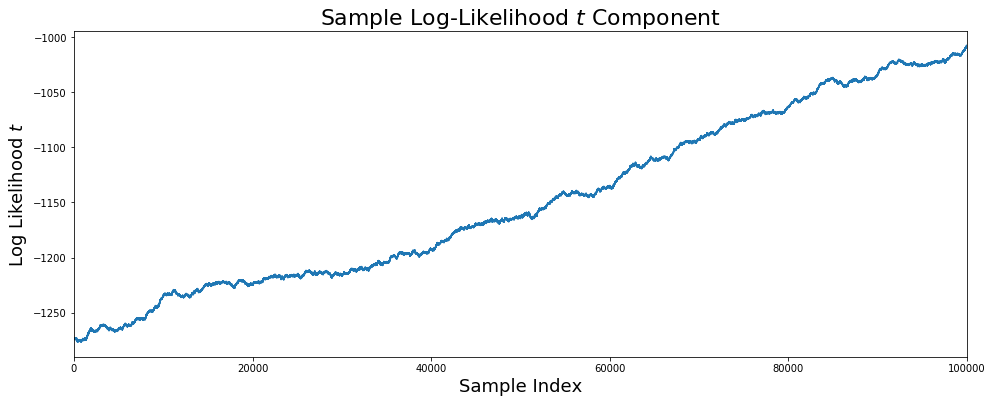

In [87]:
rcParams['figure.figsize'] = (16,6)
plt.plot(model.ll_comp_t[(n_burn-1):-1])
plt.xlim(0,n_samp)
plt.title("Sample Log-Likelihood $t$ Component", fontsize=22)
plt.ylabel("Log Likelihood $t$", fontsize=18)
plt.xlabel("Sample Index", fontsize=18);

### Likelihood $x$ Component History

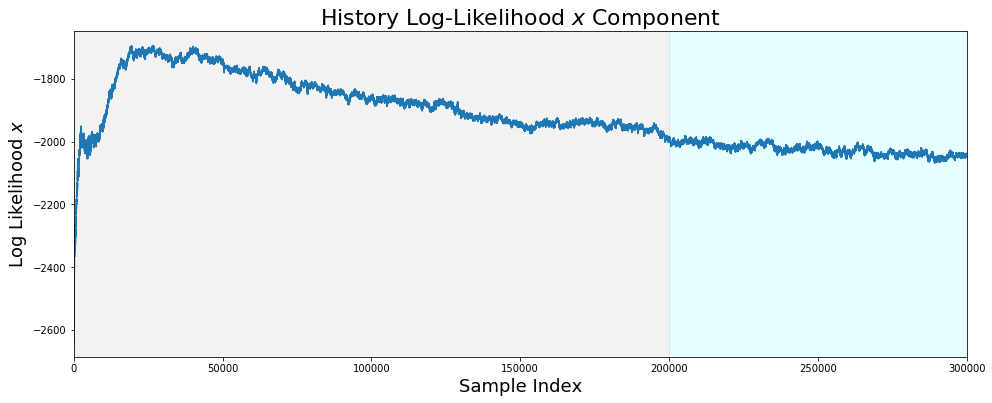

In [88]:
rcParams['figure.figsize'] = (16,6)
plt.plot(model.ll_comp_x)
plt.axvspan(0, n_burn, alpha=0.1, color='grey')
plt.axvspan(n_burn, n_samp + n_burn, alpha=0.1, color='cyan')
plt.xlim(0,n_samp + n_burn)
plt.title("History Log-Likelihood $x$ Component", fontsize=22)
plt.ylabel("Log Likelihood $x$", fontsize=18)
plt.xlabel("Sample Index", fontsize=18);

### Likelihood $x$ Component Samples

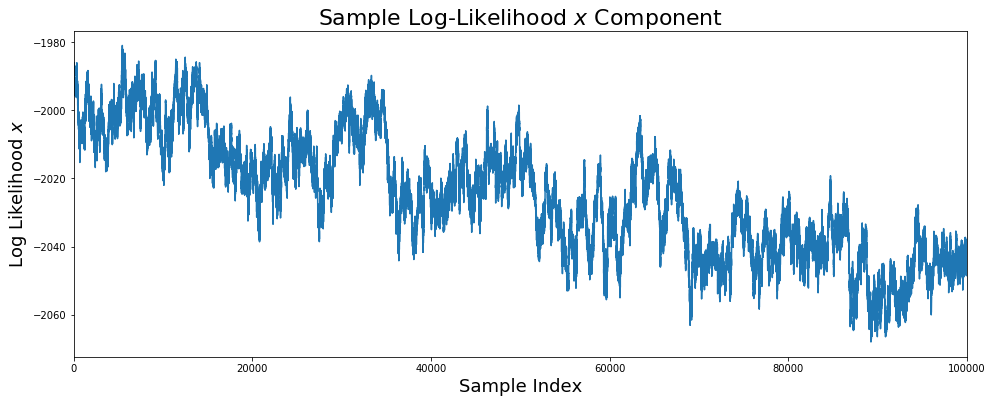

In [89]:
rcParams['figure.figsize'] = (16,6)
plt.plot(model.ll_comp_x[(n_burn-1):-1])
plt.xlim(0,n_samp)
plt.title("Sample Log-Likelihood $x$ Component", fontsize=22)
plt.ylabel("Log Likelihood $x$", fontsize=18)
plt.xlabel("Sample Index", fontsize=18);

## Pseudotime Plots

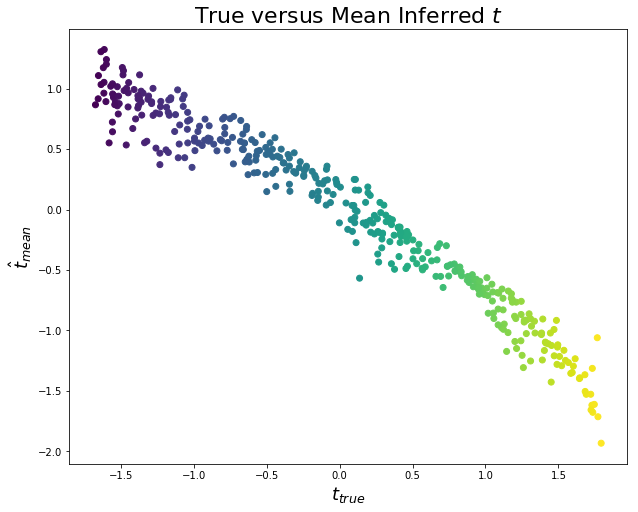

Correlation: -0.972724


In [90]:
rcParams['figure.figsize'] = (10,8)
plt.scatter(t_true, model.t_mean, c=t_true)
plt.xlabel("$t_{true}$", fontsize=18)
plt.ylabel("$\hat{t}_{mean}$", fontsize=18)
plt.title("True versus Mean Inferred $t$", fontsize=22)
plt.show()

print("Correlation: %f" % np.corrcoef(t_true.flatten(), model.t_mean.flatten())[0,1])

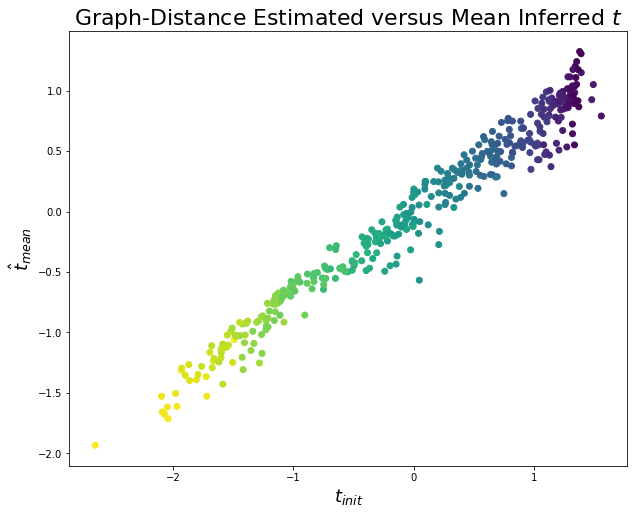

Correlation: 0.982453


In [91]:
rcParams['figure.figsize'] = (10,8)
plt.scatter(t_init, model.t_mean, c=t_true.reshape((1,N)))
plt.xlabel("$t_{init}$", fontsize=18)
plt.ylabel("$\hat{t}_{mean}$", fontsize=18)
plt.title("Graph-Distance Estimated versus Mean Inferred $t$", fontsize=22)
plt.show()
print("Correlation: %f" % np.corrcoef(t_init.flatten(), model.t_mean.flatten())[0,1])

## Expression Space Plot

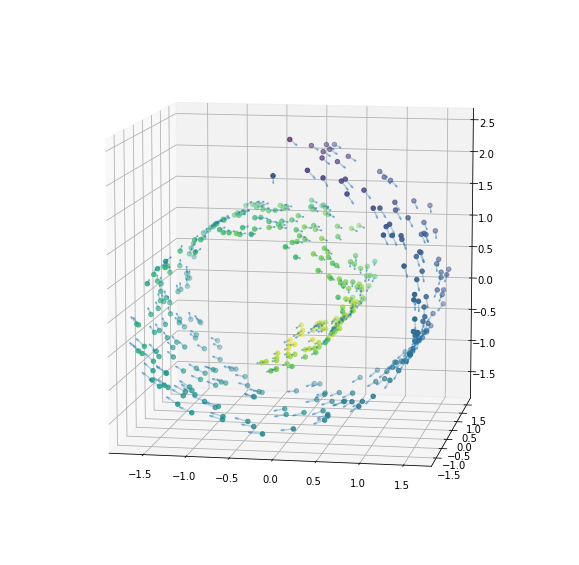

In [92]:
rcParams['figure.figsize'] = (10,10)
ax = plot_C_arrows(model.x_mean.reshape(y.shape, order="F"), model.t_mean, model.C_mean, scale_C=0.1, alpha_C=0.3)
ax.view_init(10, -80)

# Version Information

In [ ]:
%load_ext version_information
%version_information numpy, scipy, sklearn, matplotlib, version_information